In [1]:
## Plots for loop tests for which all subcats have the same number of a single LID

In [2]:
# IMPORTANT:  RUN THIS BLOCK FIRST
# ONLY for loop tests for which all subcats have the same number of a single LID:
%matplotlib inline
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
def volume_reduction_and_runoff_volume_vs_lid_number(collectionName):
    mGal = 133680.5  # 1 Million gallon in cubic feet
    runs = db[collectionName]
    cursor = runs.find()
    numList = []
    volReductionList = []
    totalSurfaceOutflowList = []
    csoVolList=[]
    noLidRun = cursor[0]
    noLidVolume = noLidRun['volume']
    outflow_series_list = []
    for run in cursor:
        runParamsZero = run['runParamList'][0] 
        number = runParamsZero['Number']
        numList.append(number)
        volume = run['volume']
        volReduction = noLidVolume-volume
        volReductionList.append(volReduction)
        outflow_series=run['outflow_series']
        #outflow_series_list.append
        series = run['outflow_series']
        #print series
        outflow_series_list.append(series)
        if run['lidDict'] == None:
            totalSurfaceOutflowList.append(None)
            continue
        else:
            totalSurfaceOutflow = 0.0
            runParamList = run['runParamList']
            lidDict = run['lidDict']
            for lidUsage in runParamList:
                lid = lidUsage['LID']
                subcat = lidUsage['Subcat']
                lidNumber = lidUsage['Number']
                #print lidNumber,
                lidArea = lidUsage['Area']  # in square feet
                lidKey = subcat+' '+lid
                surfaceOutflowInches = lidDict[lidKey]['Surface Outflow']
                surfaceOutflow = surfaceOutflowInches*lidNumber*lidArea/12.0  # cubic feet
                totalSurfaceOutflow += surfaceOutflow/mGal  # convert to million Gal/year
                
            #print totalSurfaceOutflow
            totalSurfaceOutflowList.append(totalSurfaceOutflow)


    return{"numList": numList, "outflow_series": outflow_series_list, "volReductionList": volReductionList, \
           "surface_outflow":totalSurfaceOutflowList}

### Show the collections that have been generated

In [3]:
from pymongo import MongoClient

#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"
collection = '2008trial4'
client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'second_wingo_test',
 u'y16m10d11_demonstrate_runswmm_on_aws-2']

csoplot

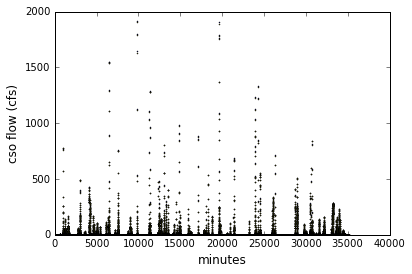

In [91]:
collectionName = '2008trial4'
#print db[collectionName]
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName)
length = len(results["outflow_series"][1])
x = range(0,length)
(fig, ax1) = plt.subplots()
ax1.plot(x,results["outflow_series"][1],'ko',color = 'b',markersize = 1)
ax1.plot(x,results["outflow_series"][9],'ko',color = 'y',markersize = 1)
ax1.set_xlabel("minutes",fontsize=12)
ax1.set_ylabel("cso flow (cfs)",fontsize=12)



In [59]:
def calculate_cso(outflow_values, ratio):
    cso_flow = 0
    hours = 0
    tot_flow = 0
    max_treatment = 3122*ratio #max cfs allowed to treatment
    #print max_treatment
    tot = len(outflow_values)
    for i in outflow_values: #out_variables is list within list (though outer list is just one element) (cfs/impervious acres)
        tot_flow += i
        if i > max_treatment:  #ratio method--- 
            cso = i - max_treatment # subtracting treated from total outflow
            cso_flow += cso 
            hours += 1
    tot_volume = tot_flow*900*7.48052 #convert to gallons, 900 seconds in 15 minutes
    cso_volume = cso_flow*900*7.48052 #for seconds in 15 minutes
    #equiv_rat = cso_volume/tot_volume  #equivalency ratio
    treated_volume = tot_volume - cso_volume
    #print tot_volume
    return {"cso_volume":cso_volume, "tot_volume":tot_volume}

[0.0, 868959.6447591782, 1732694.8943508863, 2603108.7521989346, 3464009.632763624, 4331582.389115214, 5192160.111215591, 6051714.498179913, 6918667.867475033, 7775933.21532011]


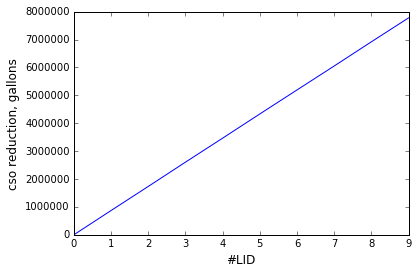

In [60]:
cso_list = []
tot_vol_list = []
cso_reduction_list = []
for i in range(0,10):
    cso = calculate_cso(results["outflow_series"][i],0.05)
    cso_list.append(cso["cso_volume"])
    tot_vol_list.append(cso["tot_volume"])
    #reduction = cso["tot_volume"] - cso["cso_volume"]
    #reduction_list.append(reduction)
for i in range(0,10):
    original_cso_volume = cso_list[0]
    cso_reduction = original_cso_volume - cso_list[i]
    cso_reduction_list.append(cso_reduction)
print cso_reduction_list
lid_num = range(0,len(cso_reduction_list))
plt.plot(lid_num, cso_reduction_list)
plt.xlabel("#LID",fontsize=12)
plt.ylabel("cso reduction, gallons",fontsize=12)    

[1404689.0533955097, 1294391.0301456451, 1180053.5261018276, 1058660.3955950737, 960103.79654490948, 868959.64475917816, 790903.41076779366, 712456.69363260269, 645630.21626400948, 573619.73853605986, 528034.1977083087, 487895.22349196672, 456939.3356282115, 434513.48471999168, 411845.26496389508, 393176.13119992614, 367175.33978402615, 337539.01564800739, 308717.32014000416, 290162.63833197951, 283652.34177604318, 269002.49140796065, 260492.65185597539, 247337.40938401222, 238719.85034400225, 220710.49844394624, 211904.43029998243, 200439.03729602695, 180584.98916399479, 164265.48673199117, 158913.17467197776, 154873.6938720122, 149386.73245200515, 149386.7324519828, 136749.89001600444, 130899.3753240034, 122288.54875198752, 112943.883167997, 112943.883167997, 112943.88316800073]


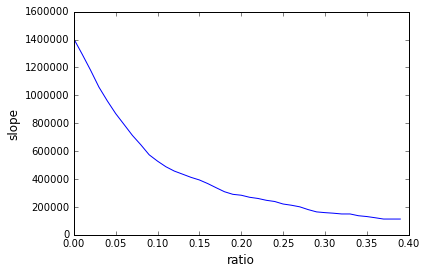

In [65]:
import numpy as np
slope_list = []
ratio_list = np.arange(0,0.4,0.01)
for j in ratio_list:
    cso_list = []
    tot_vol_list = []
    cso_reduction_list = []
    for i in range(0,10):
        cso = calculate_cso(results["outflow_series"][i],j)
        cso_list.append(cso["cso_volume"])
        tot_vol_list.append(cso["tot_volume"])
    for i in range(0,10):
        original_cso_volume = cso_list[0]
        cso_reduction = original_cso_volume - cso_list[i]
        cso_reduction_list.append(cso_reduction)
    slope = cso_reduction_list[1]-cso_reduction_list[0]
    slope_list.append(slope)
print slope_list
lid_num = range(0,len(cso_reduction_list))
plt.plot(ratio_list, slope_list)
plt.xlabel("ratio",fontsize=12)
plt.ylabel("slope",fontsize=12)    

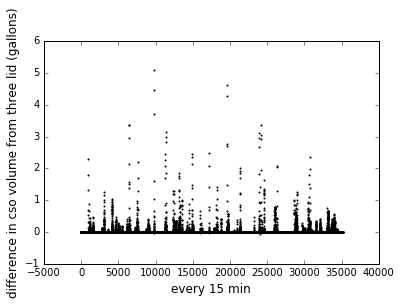

In [87]:
collectionName = '2008trial4'
diff_list = []
x = range(0,length-1)
#print db[collectionName]
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName)
length = len(results["outflow_series"][1])
for i in x: 
    diff = results["outflow_series"][0][i]-results["outflow_series"][3][i]
    diff_list.append(diff)
#x = range(0,length)
plt.scatter(x,diff_list, s=1)
plt.xlabel("every 15 min",fontsize=12)
plt.ylabel("difference in cso volume from three lid (gallons)",fontsize=12)  